## Library

In [1]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller

## Load Data & Exploration

In [2]:
# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
df.head()

,value
0,88
1,84
2,85
3,85
4,84


In [3]:
# one of transformation if residual is not satisfied the assumption (normality/ homogenity)
df_box, lam = boxcox(df.value)

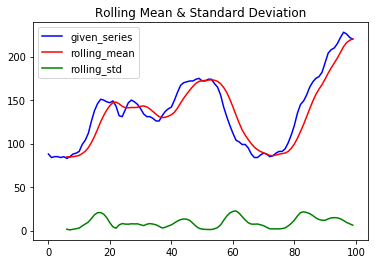

Results of Dickey-Fuller Test:
Test Statistic                 -2.464240
p-value                         0.124419
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


In [4]:
def test_for_stationary(input_data):
    r_mean = input_data.rolling(window = 7,center=False).mean()
    r_std = input_data.rolling(window = 7,center=False).std()
    
    # plotting the data
    given = plt.plot(input_data, color = 'blue', label = 'given_series')
    rolling_mean = plt.plot(r_mean, color = 'red', label = 'rolling_mean')
    rolling_std = plt.plot(r_std, color ='green', label = 'rolling_std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
     #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(input_data)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
      
test_for_stationary(df)

#### P-value > 0.05 , its mean series is not stationary

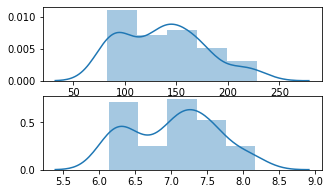

In [5]:
# distribution of boxcox data 
pyplot.figure(figsize=(5,3))
pyplot.subplot(211)
sns.distplot(df)
pyplot.subplot(212)
sns.distplot(df_box)

## Check Order of ARIMA (p, d, q)

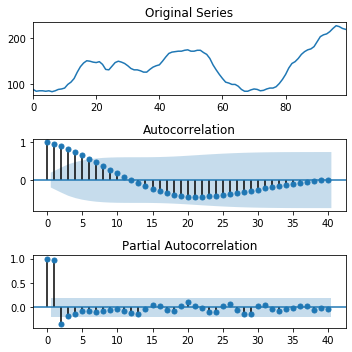

In [6]:
# Check original series
pyplot.figure(figsize=(5,5))
pyplot.subplot(311)
df.value.plot(ax=pyplot.gca(), title='Original Series')
pyplot.subplot(312)
plot_acf(df.value, lags=40,ax=pyplot.gca())
pyplot.subplot(313)
plot_pacf(df.value, lags=40, ax=pyplot.gca())

plt.tight_layout()

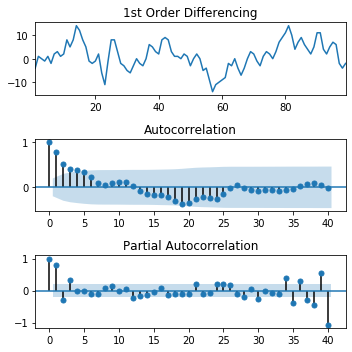

In [7]:
# Check 1st Order Differencing
pyplot.figure(figsize=(5,5))
pyplot.subplot(311)
df.value.diff().dropna().plot(ax=pyplot.gca(), title='1st Order Differencing')
pyplot.subplot(312)
plot_acf(df.value.diff().dropna(), lags=40,ax=pyplot.gca())
pyplot.subplot(313)
plot_pacf(df.value.diff().dropna(), lags=40, ax=pyplot.gca())

plt.tight_layout()

#### Model Candidate : AR(3)-I(1)-MA(0)

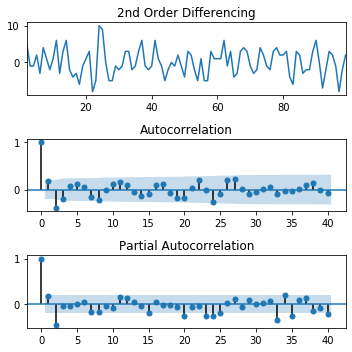

In [8]:
# 2nd Order Differencing
pyplot.figure(figsize=(5,5))
pyplot.subplot(311)
df.value.diff().diff().dropna().plot(ax=pyplot.gca(), title='2nd Order Differencing')
pyplot.subplot(312)
plot_acf(df.value.diff().diff().dropna(), lags=40,ax=pyplot.gca())
pyplot.subplot(313)
plot_pacf(df.value.diff().diff().dropna(), lags=40, ax=pyplot.gca())

plt.tight_layout()

#### Model Candidate : AR(2)-I(2)-MA(3)

## Intial Modeling

In [9]:
# 3,1,0 ARIMA Model
model = ARIMA(df.value, order=(3,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -251.832
Method:                       css-mle   S.D. of innovations              3.056
Date:                Sun, 12 Apr 2020   AIC                            513.665
Time:                        20:56:24   BIC                            526.641
Sample:                             1   HQIC                           518.915
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9799      1.650      0.594      0.553      -2.254       4.214
ar.L1.D.value     1.1460      0.095     12.017      0.000       0.959       1.333
ar.L2.D.value    -0.6593      0.135     

In [10]:
# 2,2,3 ARIMA Model
model = ARIMA(df.value, order=(2,2,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   98
Model:                 ARIMA(2, 2, 3)   Log Likelihood                -251.857
Method:                       css-mle   S.D. of innovations              3.151
Date:                Sun, 12 Apr 2020   AIC                            517.714
Time:                        20:56:25   BIC                            535.809
Sample:                             2   HQIC                           525.033
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0287      0.207      0.139      0.890      -0.377       0.434
ar.L1.D2.value    -0.2575      0.312     -0.826      0.409      -0.869       0.354
ar.L2.D2.value    -0.0843      0.241

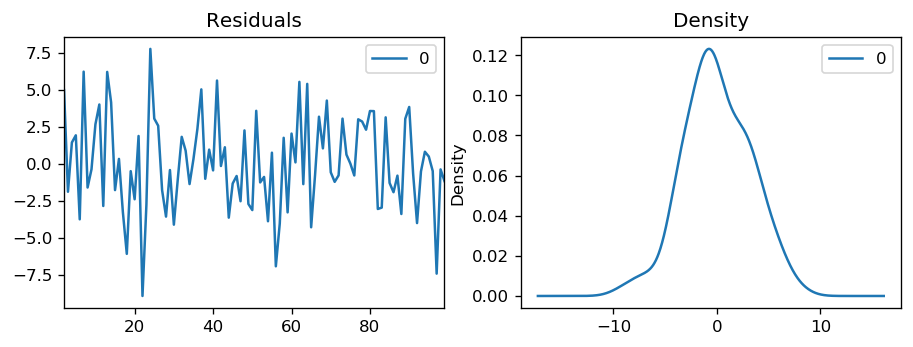

In [11]:
# Plot residual errors
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

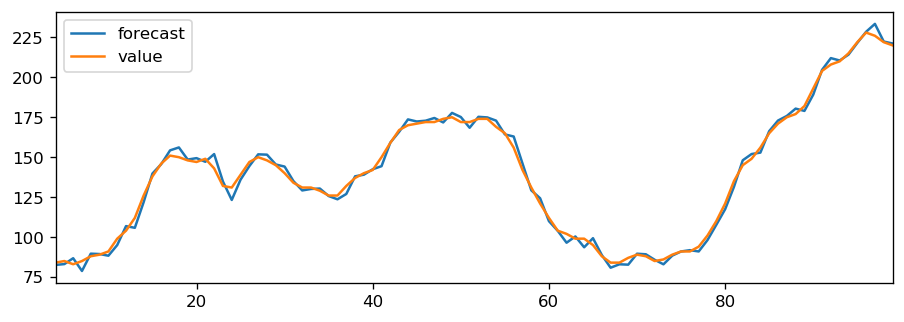

In [12]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [13]:
# Create Training and Test
train = df.value[:85]
test = df.value[85:]

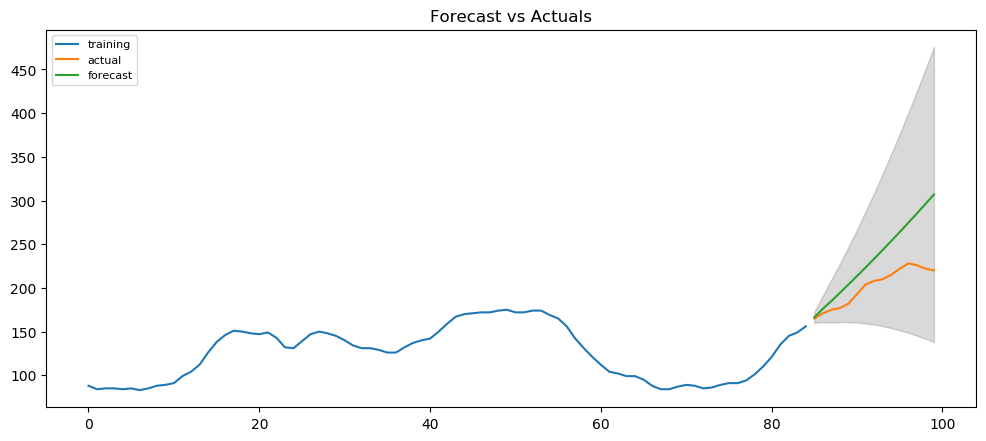

In [14]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(2, 2, 3))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

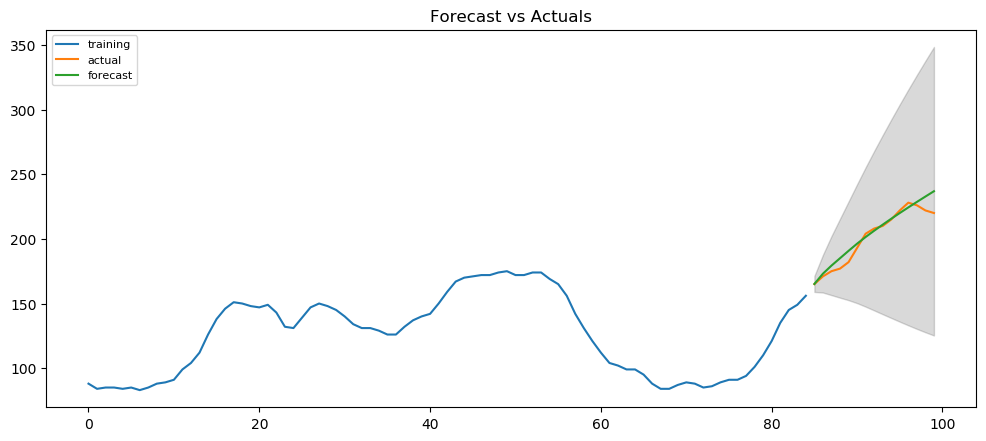

In [22]:
# Build Model
model = ARIMA(train, order=(3,2,1))  
# model = ARIMA(train, order=(2, 2, 3))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Tunning Order of ARIMA using auto_arima

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print('\nMODEL SUMMARY :',model.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=525.587, BIC=535.926, Time=0.242 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=533.474, BIC=538.644, Time=0.023 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=532.437, BIC=540.192, Time=0.070 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=525.893, BIC=533.648, Time=0.096 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=531.477, BIC=534.062, Time=0.033 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=515.248, BIC=528.173, Time=0.123 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=513.459, BIC=523.799, Time=0.084 seconds
Fit ARIMA: (3, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=515.284, BIC=528.209, Time=0.097 seconds
Fit ARIMA: (3, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=512.556, BIC=528.066, Time=0.678 seconds
Near non-invertible roots for order (3, 2, 1)(0, 0, 0, 0); setting score to inf (at least on

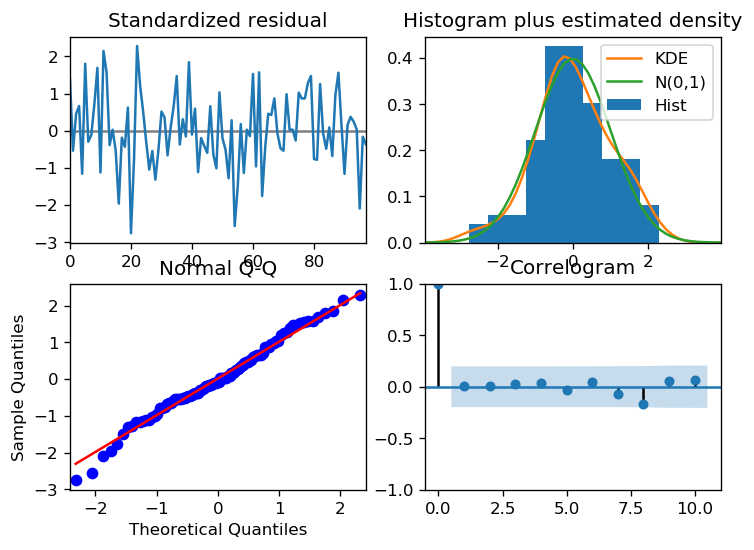

In [16]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

'Forecast Result'

,lower_bound,forecast,upper_bound
100,213.968893,220.001648,226.034402
101,205.920968,220.309018,234.697068
102,197.873671,220.338311,242.802950
103,190.738351,220.537143,250.335936
104,184.202451,221.225009,258.247566
105,177.771478,222.274024,266.776571
106,171.366948,223.479175,275.591402


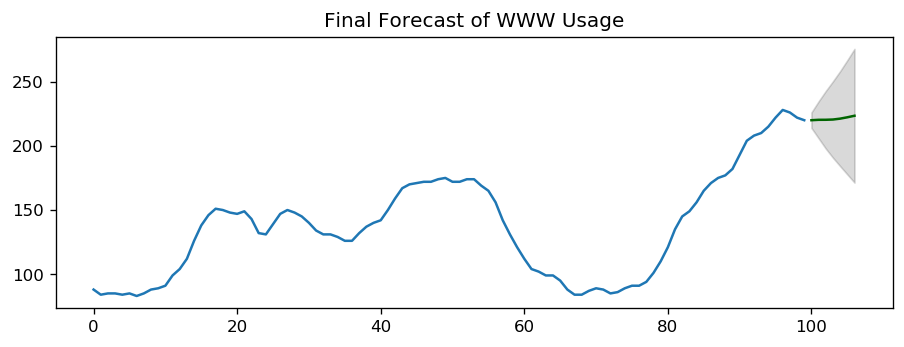

In [17]:
# Forecast
n_periods = 7
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

df_fc = pd.DataFrame({'lower_bound':confint[:, 0], 'forecast':fc, 'upper_bound':confint[:, 1]}, index=index_of_fc)
display('Forecast Result', df_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()